#### **Notebook 4: Introduction to Warp**


This notebook provides an introduction to [Warp](https://developer.nvidia.com/warp-python), a Python framework that enables developers and researchers to write GPU-accelerated and differentiable kernels. Warp allows you to leverage the power of GPUs to significantly speed up computations, making it especially useful for scientific computing, simulations, and machine learning tasks.

Throughout this tutorial, we'll cover:
1. Basic Warp operations and kernel creation
2. An N-body simulation to showcase Warp's power in complex physics calculations
3. A finite element modeling example, illustrating Warp's versatility in numerical methods
   
By the end of this notebook, you'll have a solid foundation in using Warp for GPU-accelerated computing in Python, enabling you to tackle computationally intensive tasks with improved efficiency and speed.

---
**Warp core**

Let's begin by importing the necessary libraries and initializing Warp. The `wp.init()` initializes the CUDA toolkit and driver, detects and initializes the CPU and GPU, sets up the kernel cache directory, and prints out initialization information.

In [17]:
import numpy as np
import warp as wp
import matplotlib.pyplot as plt

wp.init()

Let's start with an example. Here, we define a kernel that computes the distance of each 3D point from the origin. When we use the `@wp.kernel` decorator that indicates that this function will run on the GPU. As input we take in an array of 3D points and an array to store the computed lengths. 

Note, `tid` indicates that each thread on the GPU will process one point.

In [18]:
num_points = 1024

@wp.kernel
def length(points: wp.array(dtype=wp.vec3),
           lengths: wp.array(dtype=float)):

    tid = wp.tid()
    lengths[tid] = wp.length(points[tid])

Now we allocate an array of random 3D points and an array to store the lengths. This will be the data we pass into our `length` kernel above.

In [19]:
points = wp.array(np.random.rand(num_points, 3), dtype=wp.vec3)
lengths = wp.zeros(num_points, dtype=float)

Now we can launch our first warp kernel! In the end we are able to then print the outputed lengths!

In [20]:
wp.launch(kernel=length,
          dim=len(points),
          inputs=[points, lengths])

print(lengths)

[1.063859   0.78728193 0.63495094 ... 1.2896714  0.60687196 1.1641675 ]


We can also measure the execution time of a Warp kernel. The `ScopedTimer` context will measure how long it takes to define and compile this multiplication kernel.

In [21]:
with wp.ScopedTimer("Multiply Kernel", synchronize=True):
    @wp.kernel
    def multiply_kernel(
        a: wp.array(dtype=float),
        b: wp.array(dtype=float),
        c: wp.array(dtype=float),
    
    ):
        i = wp.tid()
        c[i] = a[i] * b[i]

Multiply Kernel took 0.47 ms


---

**N-body Sample**

Now, let's explore a more complex example: an [N-body simulation](https://developer.nvidia.com/gpugems/gpugems3/part-v-physics-simulation/chapter-31-fast-n-body-simulation-cuda). This simulation numerically approximates the evolution of a system of bodies, where each body continuously interacts with every other body.

As parameters we will take a time step, number of bodies, and a softening factor.

In [22]:
dt = 0.01
num_bodies = 1024
SOFTENING_SQ = 0.1**2

Next we will initialize arrays for positions, velocities, and masses of the bodies. Notice, we are using NumPy to generate random initial conditions on the CPU, then transfers this data to Warp arrays on the GPU for efficient computation. This is very similar to the workflow we observed with converting NumPy arrays to CuPy arrays!

In [23]:
def init_problem():
    global pos_array_0, pos_array_1, vel_array, mass_array, scale, init_pos_np
    
    rng = np.random.default_rng(42)
    scale = 10.0 * (num_bodies / 1024) ** (1 / 3)
    init_pos_np = rng.uniform(low=-scale, high=scale, size=(num_bodies, 3))
    init_vel_np = rng.uniform(low=-1.0, high=1.0, size=(num_bodies, 3))
    mass_array_np = np.ones(num_bodies)
    
    pos_array_0 = wp.array(init_pos_np, dtype=wp.vec3)
    pos_array_1 = wp.empty_like(pos_array_0)
    vel_array = wp.array(init_vel_np, dtype=wp.vec3)
    mass_array = wp.array(mass_array_np, dtype=wp.float32)


init_problem()

This function computes the acceleration of a body due to gravitational interactions with all other bodies.

In [24]:
@wp.func
def body_body_interaction(
    num_bodies: int,
    masses: wp.array(dtype=float),
    body_position: wp.vec3, 
    positions: wp.array(dtype=wp.vec3)
):

    acc = wp.vec3(0.0, 0.0, 0.0)
    for body_index in range(num_bodies):
        r = positions[body_index] - body_position
        dist_sq = wp.length_sq(r) + SOFTENING_SQ
        inv_dist = 1.0 / wp.sqrt(dist_sq)
        inv_dist_cubed = inv_dist * inv_dist * inv_dist
        acc = acc + masses[body_index] * inv_dist_cubed * r

    return acc

This code sets up the initial conditions for an N-body simulation. It defines parameters like time step, number of bodies, and a softening factor to prevent numerical instabilities. The init_problem function initializes arrays for positions, velocities, and masses of the bodies. It uses NumPy to generate random initial conditions on the CPU, then transfers this data to Warp arrays on the GPU for efficient computation.

In [25]:
@wp.kernel
def integrate_bodies(
    num_bodies: int,
    dt: float,
    masses: wp.array(dtype=float),
    old_position: wp.array(dtype=wp.vec3),
    velocity: wp.array(dtype=wp.vec3),
    new_position: wp.array(dtype=wp.vec3),
):
    i = wp.tid()
    accel = body_body_interaction(num_bodies, masses, old_position[i], old_position)
    velocity[i] = velocity[i] + accel * dt
    new_position[i] = old_position[i] + dt * velocity[i]
 

Now we need our function that will advance the simulation by one time step. The function uses global to access and modify `pos_array_0` and `pos_array_1`, which store the positions of bodies across two time steps. After the kernel execution, it swaps `pos_array_0` and `pos_array_1`. This efficient technique avoids copying data, allowing the newly calculated positions to become the current positions for the next time step.

In [26]:
def integrate():
    global pos_array_0, pos_array_1
    
    wp.launch(
        integrate_bodies,
        dim=(num_bodies,),
        inputs=[num_bodies, dt, mass_array, pos_array_0, vel_array, pos_array_1],
    )
    
    (pos_array_0, pos_array_1) = (pos_array_1, pos_array_0)

Let's reset our problem state and run 1000 steps of our simulation.

In [27]:
init_problem()

with wp.ScopedTimer("1000 Integration Steps ", synchronize=True):
    for _step_index in range(1000):
        integrate()

1000 Integration Steps  took 245.17 ms


We can take this one step further and visualizae each iteration of our simulation. Let's create a function that will update our plot according to the output of our `integration` function. 

In [28]:
def update_plot(frame):
    integrate()
    positions_cpu = pos_array_0.numpy()

    scatter_plot._offsets3d = (
        positions_cpu[:, 0],
        positions_cpu[:, 1],
        positions_cpu[:, 2],
    )
    return (scatter_plot,)

Finally, we setup the rest of the variables for our visualization!

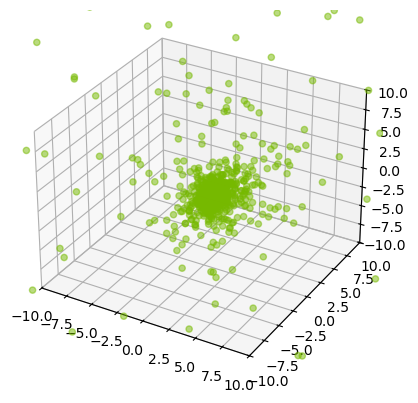

In [29]:
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
scatter_plot = ax.scatter(init_pos_np[:, 0], init_pos_np[:, 1], init_pos_np[:, 2], c="#76b900", alpha=0.5)
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_zlim(-scale, scale)

anim = FuncAnimation(fig, update_plot, frames=range(1000), interval=10, blit=True, repeat=False)

plt.show()

---

**Finite Element Modeling Example**

Finally, warp offers a flexible finite element-based (FEM/DG) framework for diffusion, convection, fluid flow, and elasticity.

This code defines a bilinear form for the diffusion equation. The `@fem.integrand decorator` indicates that this function will be used in the finite element integration process. The function takes sample points, a trial function, a test function, and a diffusion coefficient. It returns the scaled dot product of the gradients, which represents the weak form of the diffusion equation.

In [30]:
import warp.fem as fem
@fem.integrand

def diffusion_form(s: fem.Sample, u: fem.Field, v: fem.Field, nu: float):
    return nu * wp.dot(
        fem.grad(u, s),
        fem.grad(v, s),
)

We define a geometry for a simple tetrahedral mesh. The positions specifies the coordinates of the vertices, while the indices array defines how these vertices are connected to form tetrahedra. This mesh represents a cube divided into five tetrahedra.

In [31]:
positions = wp.array([
    [0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
    [1.0, 1.0, 1.0]
], dtype=wp.vec3)

indices = wp.array([
    [0, 1, 2, 4],
    [0, 1, 3, 4],
    [0, 2, 3, 4],
    [1, 2, 3, 4],
    [0, 1, 2, 3]
], dtype=wp.int32)

We create a Tetmesh object and define a polynomial function space over this geometry using [quadratic Serendipity elements](https://nvidia.github.io/warp/modules/fem.html#warp.fem.ElementBasis). This space will be used to approximate our solution.

In [32]:
geo = fem.Tetmesh(positions=positions, tet_vertex_indices=indices)
scalar_space = fem.make_polynomial_space(
geo, degree=2, element_basis=fem.ElementBasis.SERENDIPITY)

Finally, we define trial and test functions based on our scalar space. The `fem.integrate` function then assembles the stiffness matrix by integrating our bilinear form over the domain. 

In [33]:
trial = fem.make_trial(scalar_space)
test = fem.make_test(scalar_space)
matrix = fem.integrate(diffusion_form,
            fields={"u": trial, "v": test},
            values={"nu": 0.1})

print(f"Stiffness matrix dimensions: {matrix.shape}")


Module warp.fem.space.restriction.dyn.fill_element_node_indices_Tetmesh_Cells_Tetmesh_Tet_P2_Whole 310679b load on device 'cuda:0' took 278.47 ms  (compiled)
Module warp.fem.space.restriction d30099e load on device 'cuda:0' took 232.68 ms  (compiled)
Module __main__.diffusion_form d5576b5 load on device 'cuda:0' took 1371.60 ms  (compiled)
Module warp.fem.field.virtual.dyn.dispatch_bilinear_kernel_fn_TrialFieldTetmesh_Tet_P2_Tet_P2_float32_1Whole_Taylor0030_TestFieldTetmes 2d35d9d load on device 'cuda:0' took 497.49 ms  (compiled)
Stiffness matrix dimensions: (35, 35)


---

**Please restart the kernel**

In [34]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In this notebook, we've explored the fundamentals of Warp and its potential for accelerating computational tasks in Python.  Key takeaways include:

1. Warp offers a straightforward way to write GPU-accelerated kernels in Python, making it accessible to developers familiar with NumPy and similar libraries.
2. The N-body simulation demonstrated Warp's power in handling computationally intensive physics calculations efficiently.
3. The finite element modeling example showcased Warp's versatility in implementing advanced numerical methods.

This GPU-accelerated framework empowers you to tackle intricate simulations, advanced scientific computations, and complex machine learning challenges with speed and efficiency. 